Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details. 

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [73]:
from itertools import accumulate
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from tqdm.auto import tqdm
import functools

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [74]:
# #Setting 1
# UNIVERSE_SIZE = 100
# NUM_SETS = 10
# DENSITY = 0.2

# #Setting 2
UNIVERSE_SIZE = 1_000
NUM_SETS = 100
DENSITY = 0.2

# #Setting 3
# UNIVERSE_SIZE = 10_000
# NUM_SETS = 1_000
# DENSITY = 0.2

#Setting 4
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.1

# #Setting 5
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.2

# #Setting 6
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.3

MAX_STEPS = 10_000

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [75]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [76]:
def valid(solution):
    """Checks whether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)

def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

@counter
def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

In [77]:
def evaluate(solution):
    return (valid(solution), -cost(solution))

In [78]:
## Construction of initial solution
def build_init_solution():

    # Deal with duplicates if there are any
    unique_sets, unique_indices = np.unique(SETS, axis=0, return_index=True)

    # Get the number of elements each set covers as the sum of its elements
    set_sums = unique_sets.sum(axis=1)

    # Take all unique 1-element sets into the solution
    init_solution = np.full(NUM_SETS, False)
    init_solution[unique_indices[set_sums == 1]] = True

    # Consider all unique sets covering more than 1 elements as untaken sets. 
    # Sets covering 0 elements, if any, do not add value to the solution, so they're discarded
    untaken_sets = unique_sets[set_sums > 1]
    untaken_indices = unique_indices[set_sums > 1]
    untaken_sums = set_sums[set_sums > 1]

    # Add sets to the initial solution iteratively, generally preferring the ones of the smaller sum
    while not valid(init_solution) and len(untaken_sets) > 0:
        # Check how many elements are uncovered
        uncovered_elements = UNIVERSE_SIZE - np.sum(np.logical_or.reduce(SETS[init_solution], axis=0))

        sum_val = np.min(untaken_sums)
        if uncovered_elements < 2*sum_val:
            # Check if there is a set that might cover exactly the remaining elements
            # I.e. if uncovered_elements = 6 and the minimal sum of the untaken sets is 4, it might be less costly to take a set covering 6 elements
            #      instead of taking 2 sets covering 4 elements each.
            candidate_indices = np.where(untaken_sums == uncovered_elements)[0]
            if len(candidate_indices) > 0:
                sum_val = uncovered_elements
        candidate_indices = np.where(untaken_sums == sum_val)[0]
        
        if len(candidate_indices) > 0: 
            # Randomly select one set from the candidates
            random_choice = rng.choice(candidate_indices)
            selected_set_index = untaken_indices[random_choice]
            init_solution[selected_set_index] = True
            
            # If the number of uncovered elements hasn't reduced with a newly taken set, this set is discarded from the solution
            current_uncovered_elements = UNIVERSE_SIZE - np.sum(np.logical_or.reduce(SETS[init_solution], axis=0))
            if current_uncovered_elements >= uncovered_elements:
                init_solution[selected_set_index] = False

            untaken_sets = np.delete(untaken_sets, random_choice, axis=0)
            untaken_indices = np.delete(untaken_indices, random_choice, axis=0)
            untaken_sums = np.delete(untaken_sums, random_choice)

    return init_solution

In [79]:
def tweak(solution, temperature = 0.25):
    mask = rng.random(NUM_SETS) < temperature
    if not np.any(mask):
        mask[rng.choice(NUM_SETS)] = True
    new_solution = np.logical_xor(solution, mask)
    return new_solution

ic| best_eval: (np.True_

, np.float64(-10258.46561223023))


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| best_eval: (np.True_, np.float64(-6606.0639589354705))
ic| history.index(best_eval): 1414
ic| cost.calls: 10001


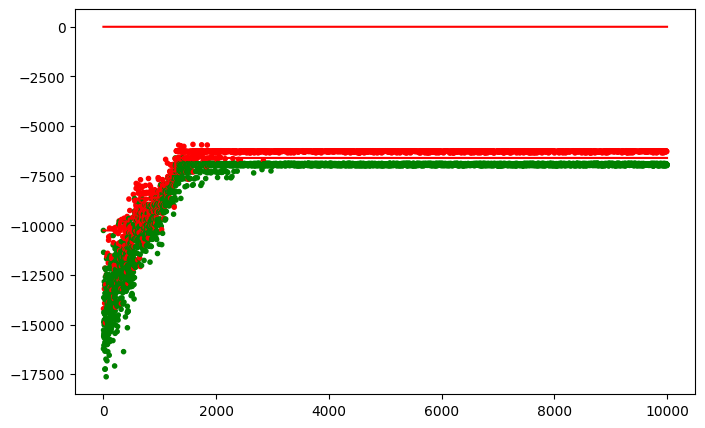

In [80]:
# Local search 
temperature = 0.3
temp_sigma = 0.9
era = 50
init_solution = build_init_solution()
best_eval = evaluate(init_solution)
ic(best_eval)
solution = init_solution.copy()
history = [best_eval]
buffer = list()
for n in tqdm(range(MAX_STEPS)):
        
    if (n > 0) and (n % era == 0):
        #check of the dynamics at the end of an era with the 1/5 success rule
        successes = np.sum(buffer[-20:])
        if successes > 4: #era/5:
            temperature = temperature/temp_sigma
        elif successes < 4: #era/5:
            temperature = temperature*temp_sigma

    new_solution = tweak(solution, temperature)
    new_eval = evaluate(new_solution)

    history.append(new_eval)
    if new_eval > best_eval:
        solution = new_solution
        best_eval = new_eval
        buffer.append(True)
    else:
        buffer.append(False)

ic(best_eval)
ic(history.index(best_eval))
ic(cost.calls)

hist_validity, hist_costs = zip(*history)
colors = ['green' if val else 'red' for val in hist_validity]

plt.figure(figsize=(8, 5))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red")
_ = plt.scatter(range(len(history)), hist_costs, marker=".", c=colors)